## Introduction

This project replicates the counterfactual part of Multidimensional Auctions of Contracts: An Empirical Analysis by Yunmi Kong, Isabelle Perrigne, and Quang Vuong published in American Economics Review in 2022. This paper analyzes cash-royalty auctions of Louisiana oil leases. In this auction, the bidders bid for a one-time cash payment and royalty (the proportion of revenues they will pay the government afterward). The winner of the auction has the right of drilling, but it is not compulsory. They model this auction as a private value auction in which each bidder draws a private productivity level $\theta_1$ and a private cost $\theta_2$ of drilling $ from a joint distribution. The private value also depends on the oil price, which is modeled as a geometric Brownian motion. I will include more details of their auction model in this notebook.

This paper estimates the joint distribution of $\theta_1$ and $\theta_2$ non-parametrically and analyzes counterfactuals based on that. In this excercise, I replicate the main idea of this paper. First, I simulate $\theta_1$ and $\theta_2$ and compute the private values and bids for each firm. Then, I estimate the government choice probability of the auction winner from data. Lastly, I generate the Guassian Coupula from the data, which is important for estimating ex-ante probability of winning. 

In this exercise, I will show the following techinques that is helpful for future research.
1. autograd (one of the most important package for deep learning, also important for optimization in economics)
2. copulas
3. seive maximun likelihood estimation
4. optimization

In [25]:
try:
    from copulas.multivariate import GaussianMultivariate
except:
    %pip install copulas
    from copulas.multivariate import GaussianMultivariate

try:
    import autograd.numpy as np  # Thinly-wrapped numpy
    from autograd import grad    # The only autograd function you may ever need
    from autograd.scipy.stats import norm, chi2
except:
    %pip install autograd
    import autograd.numpy as np  # Thinly-wrapped numpy
    from autograd import grad    # The only autograd function you may ever need
    from autograd.scipy.stats import norm, chi2

import pandas as pd
import matplotlib.pyplot as plt
from turtle import color
import math
from sklearn.preprocessing import QuantileTransformer
from scipy.optimize import minimize, fsolve
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Monte Carlo Simulation
### Generate Fake Parameters

In [6]:
numB = 1000     # number of bidders
numA = 100     # number of auctions

THETA1 =  np.maximum(0.1, np.exp(np.random.normal(size=numB)))

# when THETA2 is standard normal times 12, the mean of THETA2/THETA1 is close to 21
#   the is the average cost per barrel.
THETA2 =  12 * np.minimum(10,np.exp(np.random.normal(scale=0.5, size=numB)))

Discriptive Statistics of the Fake Parameters. $\theta_1 / \theta_2$ is the average cost per barrel.

Text(0, 0.5, 'Density')

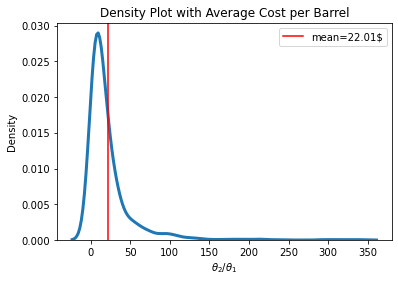

In [7]:
from turtle import color
from matplotlib.pyplot import xlabel
sns.distplot(THETA2/THETA1, hist = False, kde = True, kde_kws = {'linewidth': 3})
plt.axvline(x=np.mean(THETA2/THETA1),color='red', label='mean=' + str(round(np.mean(THETA2/THETA1),2)) + '$')
plt.legend(loc="upper right")
plt.title('Density Plot with Average Cost per Barrel')
plt.xlabel(r'$\theta_2 / \theta_1$')
plt.ylabel('Density')

### Compute the Private Values of Bidders

Let $a \in[0,1)$ be the royalty component of the bid, $\theta_1$ the firm's expected production volume, and $\theta_2$ the firm's economic cost of production, $t$ the duration in years until the lease expires, $p$ the price of oil at the time of the auction, $\sigma$ the price volatility, $r$ the one-year interest rate, and $\Phi(\cdot)$ the standard normal distribution. The oil price $p$ follows a geometric Brownian motion with volatility $\sigma$ and zero drift after adjusting for inflation. The variables $t, p, \sigma$, and $r$ are exogenous. Upon production, the firm receives the price at the time of production. A bidder's value for the lease at the time of auction is

$$V\left(a ; \theta_1, \theta_2\right)=e^{-r t}[\underbrace{(1-a) p \theta_1}_{\text {firm's share }} \Phi(x)-\theta_2 \underbrace{\Phi(x-\sigma \sqrt{t})}_{\operatorname{Pr}(\text { exercise })}]$$

where
$$x \equiv \frac{\log \left((1-a) p \theta_1 / \theta_2\right)+\sigma^2 t / 2}{\sigma \sqrt{t}}$$

In [8]:
theta1 = 0.5
theta2 = 10
r = 0.05
t = 3
p = 100
sigma=0.5

def v(a):
    x = (np.log((1-a) * p * theta1/theta2) + sigma**2 * t / 2) / (sigma * np.sqrt(t))
    v = np.exp(-r*t) * ( (1-a)*p*theta1*norm.cdf(x) + sigma**2 * t / 2 - theta2*norm.cdf(x - sigma * np.sqrt(t)))
    return v


# gradient by autograd    
grad_v = grad(v)

Plot the value agaist royalty

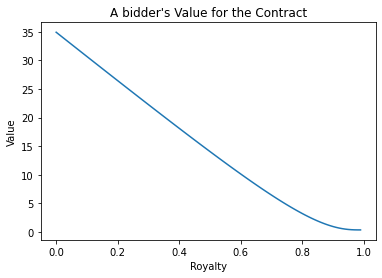

In [9]:
theta1 = 0.5
theta2 = 10
r = 0.05
t = 3
p = 100
sigma=0.5
agrids = np.arange(0, 1, 0.01)
values = [v(a) for a in agrids]
plt.title('A bidder\'s Value for the Contract')
plt.xlabel('Royalty')
plt.ylabel('Value')
plt.plot(agrids, values)

The Gradient of the value on royalty

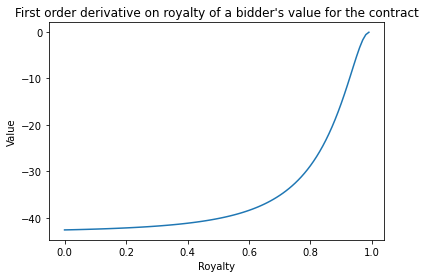

In [10]:
agrids = np.arange(0, 1, 0.01)
values = [grad_v(a) for a in agrids]
plt.title('First order derivative on royalty of a bidder\'s value for the contract')
plt.xlabel('Royalty')
plt.ylabel('Value')
plt.plot(agrids, values)

## Estimation
### The government choice probability $P(a, b)$

Using sieve maximum likelihood to estimate the government choice probability between two pairs of bids. 

In [16]:
def nchoosek(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def bernstein_bases_univariate(x, nx) :
    # sample size
    try:
        numS = len(x)
    except:
        numS = 1
    B = np.empty([numS, nx+1])
    for p in range(nx + 1):
        B[:,p] = ( nchoosek(nx,p)* x ** p ) * ((1-x) ** (nx-p)) 
    return B

def bernstein_bases_trivariate(x, y, z, nx, ny, nz) :
    '''
    Generate the bernstein bases from data
    '''
    
    # sample size
    try:
        numS = len(x)
    except:
        numS = 1

    Bx = bernstein_bases_univariate( x, nx )
    By = bernstein_bases_univariate( y, ny )
    Bz = bernstein_bases_univariate( z, nz )

    Bxym  = np.zeros((numS, nx+1, ny+1))
    Bxy   = np.zeros((numS, (nx+1)*(ny+1)))
    Bxyzm = np.zeros((numS, (nx+1)*(ny+1), nz+1))
    Bxyz  = np.zeros((numS, (nx+1)*(ny+1)*(nz+1)))

    for i in range(numS):
        Bxym[i,:,:] = np.outer(Bx[i,:], By[i,:])

    for i in range(numS):
        Bxy[i,:] = Bxym[i,:,:].flatten()
    
    for i in range(numS):
        Bxyzm[i,:,:] = np.outer(Bxy[i,:], Bz[i,:])

    for i in range(numS):
        Bxyz[i,:] = Bxyzm[i,:,:].flatten()

    return Bxyz

def gchoice_L(beta) :
    '''
    Log likelihood function
    '''
    P = bases @ beta
    P = np.maximum(0.000001, P)
    P = np.minimum(0.99999, P)
    L = np.sum(win * np.log(P) + (1-win) * np.log(1-P))
    return -L

def gchoice_fun(dcn, drn, index = 0.5):
    '''
    Probibility of winning
    '''
    return (bernstein_bases_trivariate(dcn, drn, index, nx, ny, nz) @ beta)[0]

#### Read Data

variables are 

win     - winning dummy

diffr   - difference between the winning roylty bid and the losing royalty bid

lndiffc - difference between log of the winning cash bid and the losing cash bid

index   - an index that summerize all other coviariate (the charateristic of the lease)

In [17]:
filename = 'Data_for_gchoice.csv';
GOV = pd.read_csv(filename)
GOV_SUB = GOV[['win', 'diffr', 'lndiffc', 'index']]
GOV_SUB.head(5)

,win,diffr,lndiffc,index
0,0,-0.033333,0.105675,0.296
1,1,0.033333,-0.105675,0.296
2,0,-0.033333,0.043064,0.200
3,1,0.033333,-0.043064,0.200
4,0,0.000000,-0.082144,0.878


#### Sieve MLE

In [20]:
qt = QuantileTransformer()

GOV_X = GOV_SUB[['diffr', 'lndiffc']]
# standization of the data
GOV_STD = qt.fit_transform(GOV_X)

x = GOV_STD[:,0]
y = GOV_STD[:,1]
z = GOV['index'].array.to_numpy()

win = GOV.win.array.to_numpy()

# orders of the seive estimation bernstein polynomial
nx = 6
ny = 6
nz = 2

# generate the bernstein bases from data
bases = bernstein_bases_trivariate(x, y, z, nx, ny, nz)

# sample size
numS = bases.shape[0]

# gradient by autograd
grad_gchoice_L = grad(gchoice_L)

# initial guesses
init = tuple([0.5]*147)

# mle
result = minimize(gchoice_L, init, method='SLSQP', bounds=[(0,1)]*147, jac=grad_gchoice_L)

# get estimated parameters for the bernstein polynomial if the optimization succeeded 
beta = result.x if result.success else np.nan

result.success

True

#### Plot

This is the figure 3 in the original paper.

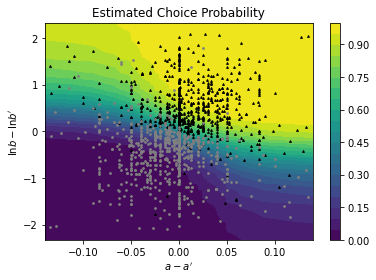

In [22]:
numGRID = 100

a_qt = np.linspace(0.01, 0.99, numGRID)
b_qt = np.linspace(0.01, 0.99, numGRID)
A_qt, B_qt = np.meshgrid(a_qt, b_qt)

f = np.frompyfunc(gchoice_fun, 2, 1)
P = f(A_qt, B_qt)

# The bids were standadized to quantiles, now we need to transform it back to actual bids
a = qt.inverse_transform(np.vstack((a_qt, b_qt)).T)[:,0]
b = qt.inverse_transform(np.vstack((a_qt, b_qt)).T)[:,1]
A, B = np.meshgrid(a, b)

im = plt.contourf(A, B, P, 20, cmap='viridis')
plt.colorbar(im)
GOV_PLOT = GOV_SUB[ (GOV_SUB['diffr'] < 0.14) & (GOV_SUB['diffr'] > -0.14) & (GOV_SUB['lndiffc'] < 2.1) & (GOV_SUB['lndiffc'] > -2.1)]
GOV_PLOT_WIN  = GOV_PLOT[GOV_PLOT['win'] == 1]
GOV_PLOT_LOSS = GOV_PLOT[GOV_PLOT['win'] == 0]
plt.scatter(GOV_PLOT_WIN.diffr,GOV_PLOT_WIN.lndiffc,c ="black", marker='^', s=3)
plt.scatter(GOV_PLOT_LOSS.diffr,GOV_PLOT_LOSS.lndiffc,c ="grey", marker='o', s=3)
plt.xlabel(r'$a - a^\prime$')
plt.ylabel(r'$\ln b - \ln b^\prime$')
plt.title('Estimated Choice Probability')
plt.show()


### Sample from joint density of two 2-D bids
We simulate more data from the original dataset. by copula. Marginal densities are estimated via kernels and affiliation is estimated via Gaussian copula. In Python, this can be done easily with GaussianMultivariate class in copulas.multivariate package.

In [26]:
BIDS = pd.read_csv('Data_for_kdensity.csv')
BIDS

,roy_dm,lncpad_dm,accbid
0,0.012741,-0.142119,1
1,-0.020593,-0.036445,0
2,0.008937,0.055362,1
3,-0.024396,0.098425,0
4,-0.001684,1.158188,1
...,...,...,...
899,-0.051214,-0.321059,0
900,0.022731,-0.501388,0
901,0.022731,-0.180459,1
902,-0.031481,0.437533,1


Sample is the true dataset where (a, b) are winning bids and (a0, b0) are the corresponding losing bid.

In [28]:
BIDS_WIN   = BIDS[BIDS['accbid'] == 1].reset_index().drop(columns=['index', 'accbid']).rename(columns={'roy_dm' : 'a', 'lncpad_dm' : 'b'})
BIDS_LOSS  = BIDS[BIDS['accbid'] == 0].reset_index().drop(columns=['index', 'accbid']).rename(columns={'roy_dm' : 'a0', 'lncpad_dm' : 'b0'})
SAMPLE = pd.concat([BIDS_WIN, BIDS_LOSS], axis=1)
SAMPLE

,a,b,a0,b0
0,0.012741,-0.142119,-0.020593,-0.036445
1,0.008937,0.055362,-0.024396,0.098425
2,-0.001684,1.158188,0.218316,-0.525739
3,-0.000209,1.693100,0.083125,0.991736
4,-0.026788,0.605619,-0.026788,0.241175
...,...,...,...,...
447,0.017153,1.314598,0.042153,0.649905
448,0.006287,-0.188547,0.006287,-0.792542
449,-0.021214,-0.666975,-0.051214,-0.321059
450,0.022731,-0.180459,0.022731,-0.501388


SYNTHETIC is the simulated data which contains 5000 samples. 

In [29]:
model = GaussianMultivariate()
SYNTHETIC = model.fit(SAMPLE)
SYNTHETIC = model.sample(5000)
SYNTHETIC

,a,b,a0,b0
0,-0.004183,0.553822,0.031455,0.331828
1,0.020022,0.938501,0.020763,0.222839
2,0.026394,0.119989,-0.020939,-0.411548
3,0.077606,1.080646,0.002431,0.796982
4,0.041790,0.537189,0.037031,-0.628456
...,...,...,...,...
4995,0.018058,1.417156,0.021886,0.794914
4996,0.077956,-0.242649,0.027833,-0.820929
4997,0.021106,0.115560,0.015172,-1.305101
4998,0.011301,-0.217604,0.010443,-0.251787


## Compute the Optimal Cash-Royalty Bidding

Given his type $\left(\theta_{1 i}, \theta_{2 i}\right)$, bidder $i$ chooses his bid $\left(a_i, b_i\right)$ to maximize his expected utility from the auction given his winning probability $P\left(\cdot, \cdot \mid \theta_{1 i}, \theta_{2 i}, n\right)$. His maximization problem is 
\begin{equation*}
\max _{a, b}\left[V\left(a ; \theta_{1 i}, \theta_{2 i}\right)-b\right] P\left(a, b \mid \theta_{1 i}, \theta_{2 i}, n\right)
\end{equation*}

We now omit the index $i$ for sake of simplicity. Differentiating with respect to $a$ and $b$, the first-order conditions give
$$
\begin{gathered}
V_a\left(a ; \theta_1, \theta_2\right)=-\frac{P_a\left(a, b \mid \theta_1, \theta_2, n\right)}{P_b\left(a, b \mid \theta_1, \theta_2, n\right)}, \\
V\left(a ; \theta_1, \theta_2\right)=b+\frac{P\left(a, b \mid \theta_1, \theta_2, n\right)}{P_b\left(a, b \mid \theta_1, \theta_2, n\right)} .
\end{gathered}
$$


#### Independent Private Values
I first consider the independent private values (IPV) case. I assume that $(\theta_{1i}, \theta_{2i})$ are i.i.d aross $i$. Nothe that this is different from the affliated private values (APV) model used by the original paper. APV allows correlation between $(\theta_{1i}, \theta_{2i})$ across samples. This paper finds high correlations between bidders (0.81 for production and 0.90 for cost), suggesting that APV is a better assumption.


The IPV assumption implies that the $P\left(\cdot, \cdot \mid \theta_{1}, \theta_{2}, n\right) = P\left(\cdot, \cdot \mid n\right)$, and $n = 2$ for each auction. The paper estimates this probablity from data, I will simplify the probability as follow.

In [65]:
def foc_bid(a, b) : 
    

26.466816063750862

In [30]:
a_qt = np.linspace(0.01, 0.99, numGRID)
b_qt = np.linspace(0.01, 0.99, numGRID)
A_qt, B_qt = np.meshgrid(a_qt, b_qt)
A_qt

array([[0.01      , 0.01989899, 0.02979798, ..., 0.97020202, 0.98010101,
        0.99      ],
       [0.01      , 0.01989899, 0.02979798, ..., 0.97020202, 0.98010101,
        0.99      ],
       [0.01      , 0.01989899, 0.02979798, ..., 0.97020202, 0.98010101,
        0.99      ],
       ...,
       [0.01      , 0.01989899, 0.02979798, ..., 0.97020202, 0.98010101,
        0.99      ],
       [0.01      , 0.01989899, 0.02979798, ..., 0.97020202, 0.98010101,
        0.99      ],
       [0.01      , 0.01989899, 0.02979798, ..., 0.97020202, 0.98010101,
        0.99      ]])

In [46]:

a = 2
b = 1000
a0 = 1
b0 = 100

lnb = np.log(b)
lnb0 = np.log(b0)

diffa = a - a0
diffb = lnb - lnb0

qt.transform(np.array([diffa, diffb]).reshape(1,2))

qt.


array([[1.        , 0.98939361]])

In [42]:
np.vstack((a_qt, b_qt)).T.shape

(100, 2)